### Notebook for analzying trading data 2025 R5

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from tabulate import tabulate
from scipy.stats import percentileofscore

def compute_price_percentile_rank(price_csv, trades_csv, trader_name="Caesar", side="buy", window=500, products=None):
    # Load CSVs
    #prices = pd.read_csv(price_csv, delimiter=';')
    #trades = pd.read_csv(trades_csv, delimiter=';')
    prices = price_csv
    trades = trades_csv

    # Compute midprices
    prices["mid_price"] = (prices["ask_price_1"] + prices["bid_price_1"]) / 2

    # Filter trades for trader and side
    if side == "buy":
        trader_trades = trades[trades["buyer"] == trader_name]
    else:
        trader_trades = trades[trades["seller"] == trader_name]

    # Filter products if provided
    if products:
        trader_trades = trader_trades[trader_trades["symbol"].isin(products)]

    results = []

    for _, trade in trader_trades.iterrows():
        timestamp = trade["timestamp"]
        symbol = trade["symbol"]
        trade_price = trade["price"]

        # Slice surrounding midprices from prices
        price_slice = prices[
            (prices["product"] == symbol) &
            (prices["timestamp"] >= timestamp - window) &
            (prices["timestamp"] <= timestamp + window)
        ]

        if len(price_slice) < 5:
            continue  # skip if insufficient price data

        percent_rank = percentileofscore(price_slice["mid_price"], trade_price)

        results.append({
            "timestamp": timestamp,
            "symbol": symbol,
            "price": trade_price,
            "percentile": round(percent_rank, 2)
        })

    return pd.DataFrame(results)

def plot_trader_activity(price_csv, trades_csv, trader_name, symbol, side="buys"):
    # Load CSVs
    prices = pd.read_csv(price_csv, delimiter=";")
    trades = pd.read_csv(trades_csv, delimiter=";")

    # Ensure timestamp is int
    prices["timestamp"] = prices["timestamp"].astype(int)
    trades["timestamp"] = trades["timestamp"].astype(int)

    # Compute mid-price for selected symbol
    symbol_prices = prices[prices["product"] == symbol].copy()
    symbol_prices["mid_price"] = (symbol_prices["ask_price_1"] + symbol_prices["bid_price_1"]) / 2

    # Filter trades for trader and symbol
    if side == "buys":
        filtered_trades = trades[(trades["buyer"] == trader_name) & (trades["symbol"] == symbol)]
        color = "green"
        label = f"{trader_name} buys"
    elif side == "sells":
        filtered_trades = trades[(trades["seller"] == trader_name) & (trades["symbol"] == symbol)]
        color = "red"
        label = f"{trader_name} sells"
    else:
        raise ValueError("side must be 'buys' or 'sells'")

    # Determine time splits
    min_time = symbol_prices["timestamp"].min()
    max_time = symbol_prices["timestamp"].max()
    segment_length = (max_time - min_time) // 3
    boundaries = [min_time + i * segment_length for i in range(4)]

    # Create plot with 3 subplots (not sharing x-axis)
    fig, axs = plt.subplots(3, 1, figsize=(14, 10))
    fig.suptitle(f"{symbol} Mid-Price with {label} — Split by Time", fontsize=16)

    for i in range(3):
        start = boundaries[i]
        end = boundaries[i + 1]
        price_slice = symbol_prices[(symbol_prices["timestamp"] >= start) & (symbol_prices["timestamp"] < end)]
        trade_slice = filtered_trades[(filtered_trades["timestamp"] >= start) & (filtered_trades["timestamp"] < end)]

        axs[i].plot(price_slice["timestamp"], price_slice["mid_price"], color="black", label="Mid-price")
        if not trade_slice.empty:
            axs[i].scatter(trade_slice["timestamp"], trade_slice["price"],
                           color=color, marker="x", s=60, label=label)

        axs[i].set_xlim(start, end)
        axs[i].set_title(f"Time {start}–{end}")
        axs[i].set_ylabel("Price")
        axs[i].grid(True)
        axs[i].legend()

    axs[-1].set_xlabel("Timestamp")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

def label_trade_quality(df):
    def classify(pct):
        if pct <= 33:
            return "Low"
        elif pct <= 66:
            return "Mid"
        else:
            return "High"

    df["category"] = df["percentile"].apply(classify)
    return df

def summarize_trade_categories(df):
    """
    Summarize the percentage of Low, Mid, and High trades per symbol.
    """
    # Count number of trades per category per symbol
    counts = df.groupby(['symbol', 'category']).size().unstack(fill_value=0)

    # Compute percentages
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100

    # Round for nicer display
    return percentages.round(1).sort_index()

In [11]:
df1 = pd.read_csv('data/2025/round5/trades_round_5_day_2.csv', delimiter=';')
df2 = pd.read_csv('data/2025/round5/trades_round_5_day_3.csv', delimiter=';')
df3 = pd.read_csv('data/2025/round5/trades_round_5_day_4.csv', delimiter=';')
df = pd.concat([df1, df2, df3], ignore_index=True)


**Basic exploration**

In [12]:
summary = {
    "unique_symbols": df["symbol"].nunique(),
    "unique_traders": len(set(df["buyer"]).union(set(df["seller"]))),
    "num_trades": len(df),
    "symbols": df["symbol"].value_counts(),
    "top_buyers": df["buyer"].value_counts().head(5),
    "top_sellers": df["seller"].value_counts().head(5),
}
print(summary["unique_traders"])

11


In [13]:
print(summary["top_buyers"])

buyer
Camilla     13053
Caesar      12598
Paris       10512
Charlie     10123
Penelope     3666
Name: count, dtype: int64


In [14]:
print(summary["top_sellers"])

seller
Caesar     16931
Paris      12135
Charlie     7183
Camilla     5885
Pablo       5672
Name: count, dtype: int64


**For each of the eleven traders, check what they trade most**

In [15]:
# Get list of all unique traders
traders = set(df["buyer"]).union(set(df["seller"]))

# Build summary table
summary = []

for trader in sorted(traders):
    bought = (
        df[df["buyer"] == trader]["symbol"]
        .value_counts()
        .head(6)
        .to_dict()
    )
    sold = (
        df[df["seller"] == trader]["symbol"]
        .value_counts()
        .head(6)
        .to_dict()
    )

    summary.append({
        "Trader": trader,
        "Top 6 Bought": ", ".join(f"{sym} ({cnt})" for sym, cnt in bought.items()),
        "Top 6 Sold": ", ".join(f"{sym} ({cnt})" for sym, cnt in sold.items()),
    })

# Display summary as a table
print(tabulate(summary, headers="keys", tablefmt="grid"))

+----------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Trader   | Top 6 Bought                                                                                                                                                                                      | Top 6 Sold                                                                                                                                                                         |
+==========+===================================================================================================================================================================================================+============

Looking at the above table, I think it is best to focus on the most active traders:
- Caesar (most bought: jams, croissants, djembes -- most sold V_9750, V_10000, V_9500)
- Camilla (most bought: V_9750, V_9500, V_10000 -- most sold: kelp, squid, resin)
- Charlie (most bought: squid, kelp, resin -- most sold: kelp, squid, resin)
- Paris (most bought: kelp, squid, djembes -- most sold: kelp, squid, resin)

Now we will look into their trades, to see if they bought/sold high/low.   

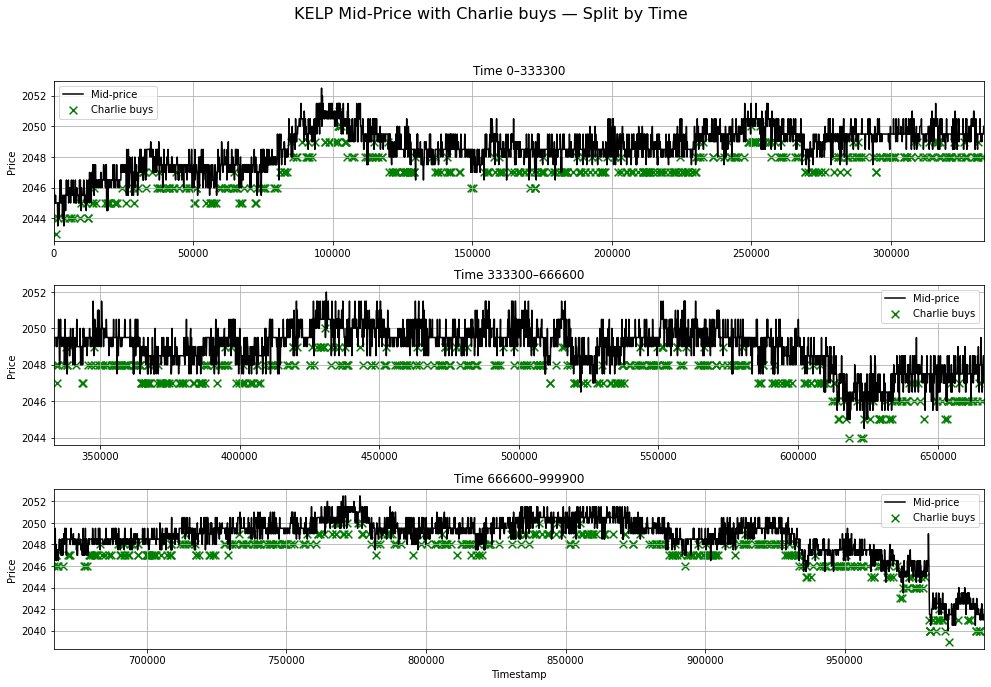

In [16]:
plot_trader_activity(
    "data/2025/round5/prices_round_5_day_2.csv",
    "data/2025/round5/trades_round_5_day_2.csv",
    trader_name="Charlie",
    symbol="KELP",
    side="buys"
)

Okay so this is all kinda hard to read. I first put a whole day in one plot but that made the markers impossible to read and even now - with splitting the day up in 3 parts - it is still kinda hard to see. We're gonna try it another way. (Update: I first plotted one for Charlie and JAMS and that one was really unclear, but tbh this one for Charlie and KELP is better, we can clearly see that the man buys low, the statistics in the next cells will confirm this btw!)

So here we assess whether a trader tends to buy at high or low prices relative to the market by calculating the percentile rank of each trade. For every trade we compare the trader’s execution price to the distribution of mid-prices observed in a short window around that timestamp (500). A low percentile indicates a favorable (low) buy price relative to the market, while a high percentile suggests the trader paid more than most. These are the thresholds: 
- low: <= 33
- mid: 34 - 66
- high: > 66

In [17]:
# Prepare data
df1 = pd.read_csv('data/2025/round5/trades_round_5_day_2.csv', delimiter=';')
df2 = pd.read_csv('data/2025/round5/trades_round_5_day_3.csv', delimiter=';')
df3 = pd.read_csv('data/2025/round5/trades_round_5_day_4.csv', delimiter=';')
df2['timestamp'] += 1_000_000
df3['timestamp'] += 2 * 1_000_000
df_trades = pd.concat([df1, df2, df3], ignore_index=True)
df_all = df_trades.sort_values("timestamp").reset_index(drop=True)

df1 = pd.read_csv('data/2025/round5/prices_round_5_day_2.csv', delimiter=';')
df2 = pd.read_csv('data/2025/round5/prices_round_5_day_3.csv', delimiter=';')
df3 = pd.read_csv('data/2025/round5/prices_round_5_day_4.csv', delimiter=';')
df2['timestamp'] += 1_000_000
df3['timestamp'] += 2 * 1_000_000
df_prices = pd.concat([df1, df2, df3], ignore_index=True)
df_prices = df_prices.sort_values("timestamp").reset_index(drop=True)


#### Caesar buys and sells

In [18]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Caesar", side="buy", window=500,
    products=["JAMS", "CROISSANTS", "DJEMBES", "VOLCANIC_ROCK", "VOLCANIC_ROCK_VOUCHER_9750", "VOLCANIC_ROCK_VOUCHER_9500"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- CAESAR BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Caesar", side="sell", window=500,
    products=["VOLCANIC_ROCK_VOUCHER_9750", "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_10250", "VOLCANIC_ROCK", "DJEMBES"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- CAESAR SELLS SUMMARY --")
print(summary_df)

-- CAESAR BUYS SUMMARY --
category                    High   Low   Mid
symbol                                      
CROISSANTS                   2.6  80.8  16.6
DJEMBES                      6.1  57.4  36.5
JAMS                         2.2  78.9  18.9
VOLCANIC_ROCK               13.8  41.8  44.5
VOLCANIC_ROCK_VOUCHER_9500  69.7  13.6  16.7
VOLCANIC_ROCK_VOUCHER_9750  70.7  13.0  16.3
-- CAESAR SELLS SUMMARY --
category                     High   Low   Mid
symbol                                       
DJEMBES                      67.7   4.7  27.6
VOLCANIC_ROCK                22.6  31.9  45.5
VOLCANIC_ROCK_VOUCHER_10000  64.1  18.3  17.6
VOLCANIC_ROCK_VOUCHER_10250  58.5  30.9  10.6
VOLCANIC_ROCK_VOUCHER_9500   63.3  16.2  20.5
VOLCANIC_ROCK_VOUCHER_9750   63.8  16.4  19.8


**Caesar takeaways:** bro is a goat, he buys low and sells high. Best to avoid trading with this guy and instead mirror his trades, Like if we see that Caeser just loaded up on JAMS then we could do the same

#### Camilla buys and sells

In [19]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Camilla", side="buy", window=500,
    products=["VOLCANIC_ROCK_VOUCHER_9750", "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_10000", "VOLCANIC_ROCK_VOUCHER_10250", "VOLCANIC_ROCK_VOUCHER_10500", "SQUID_INK"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- CAMILLA BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Camilla", side="sell", window=500,
    products=["JAMS", "SQUID_INK", "KELP", "CROISSANTS", "VOLCANIC_ROCK_VOUCHER_9750", "VOLCANIC_ROCK_VOUCHER_9500"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- CAMILLA SELLS SUMMARY --")
print(summary_df)

-- CAMILLA BUYS SUMMARY --
category                     High   Low   Mid
symbol                                       
SQUID_INK                     3.4  69.5  27.0
VOLCANIC_ROCK_VOUCHER_10000  52.7  24.5  22.9
VOLCANIC_ROCK_VOUCHER_10250  46.8  40.5  12.8
VOLCANIC_ROCK_VOUCHER_10500  42.4  54.3   3.3
VOLCANIC_ROCK_VOUCHER_9500   50.0  23.4  26.5
VOLCANIC_ROCK_VOUCHER_9750   50.8  23.6  25.6
-- CAMILLA SELLS SUMMARY --
category                    High   Low   Mid
symbol                                      
CROISSANTS                   2.4  80.2  17.4
JAMS                         3.2  75.1  21.7
KELP                        77.9   2.9  19.2
SQUID_INK                   43.2  12.8  44.0
VOLCANIC_ROCK_VOUCHER_9500  52.2  12.7  35.1
VOLCANIC_ROCK_VOUCHER_9750  53.8  13.1  33.1


**Camilla takeaways:** Not a bad trader per se but also not a super clear pattern (voucher buys high 50% of the time..), except when it comes to selling high KELP and RESIN. Maybe best to just ignore this one. It's too much work to add code for all 11 traders in our algo anyway

#### Charlie buys and sells

In [20]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Charlie", side="buy", window=500,
    products=["SQUID_INK", "KELP", "RAINFOREST_RESIN", "PICNIC_BASKET2", "MAGNIFICENT_MACARONS", "PICNIC_BASKET1"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- CHARLIE BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Charlie", side="sell", window=500,
    products=["KELP", "SQUID_INK", "RAINFOREST_RESIN", "MAGNIFICENT_MACARONS", "PICNIC_BASKET2", "PICNIC_BASKET1"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- CHARLIE SELLS SUMMARY --")
print(summary_df)

-- CHARLIE BUYS SUMMARY --
category              High   Low   Mid
symbol                                
KELP                   0.0  97.9   2.1
MAGNIFICENT_MACARONS   0.0  79.5  20.5
PICNIC_BASKET1         0.0  82.4  17.6
PICNIC_BASKET2         2.1  73.5  24.4
RAINFOREST_RESIN       0.0  93.7   6.3
SQUID_INK              4.2  70.3  25.5
-- CHARLIE SELLS SUMMARY --
category              High   Low   Mid
symbol                                
KELP                  95.8   0.1   4.1
MAGNIFICENT_MACARONS  82.8   0.3  16.9
PICNIC_BASKET1        66.7  11.1  22.2
PICNIC_BASKET2        73.8   1.9  24.3
RAINFOREST_RESIN      93.1   0.0   6.9
SQUID_INK             66.3   6.0  27.7


**Takeaways Charlie:** Forget what I said about Caesar, this dude is the real deal. I think in our algo we must include some mirroring trade logic (for KELP, RESIN and SQUID)

#### Paris buys and sells 

In [21]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Paris", side="buy", window=500,
    products=["KELP", "SQUID_INK", "DJEMBES", "RAINFOREST_RESIN", "JAMS", "CROISSANTS"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PARIS BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Paris", side="sell", window=500,
    products=["KELP", "SQUID_INK", "RAINFOREST_RESIN", "DJEMBES", "JAMS", "CROISSANTS"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PARIS SELLS SUMMARY --")
print(summary_df)

-- PARIS BUYS SUMMARY --
category          High   Low   Mid
symbol                            
CROISSANTS        88.2   1.1  10.7
DJEMBES           67.7   4.7  27.6
JAMS              85.9   1.2  12.9
KELP              87.6   4.7   7.7
RAINFOREST_RESIN  84.5   5.2  10.3
SQUID_INK         54.0  11.1  34.9
-- PARIS SELLS SUMMARY --
category          High   Low   Mid
symbol                            
CROISSANTS         2.6  81.3  16.1
DJEMBES            5.9  57.3  36.8
JAMS               1.6  79.9  18.5
KELP               2.7  95.4   1.9
RAINFOREST_RESIN   6.7  83.5   9.8
SQUID_INK          4.3  71.1  24.7


**Takeaways Paris:** lmaooo a real buy high sell low trader. Let's buy KELP or RESIN from Paris if she sells

**Alright fuck it let's check the rest of the traders too lol**

#### Gary buys and sells

In [22]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Gary", side="buy", window=500,
    products=["KELP", "SQUID_INK", "RAINFOREST_RESIN"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- GARY BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Gary", side="sell", window=500,
    products=["SQUID_INK", "KELP", "RAINFOREST_RESIN"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- GARY SELLS SUMMARY --")
print(summary_df)

-- GARY BUYS SUMMARY --
category          High  Low   Mid
symbol                           
KELP              89.1  5.3   5.6
RAINFOREST_RESIN  92.6  5.7   1.7
SQUID_INK         70.2  3.3  26.4
-- GARY SELLS SUMMARY --
category          High   Low   Mid
symbol                            
KELP               7.5  89.6   2.9
RAINFOREST_RESIN   6.8  88.0   5.2
SQUID_INK          5.3  67.7  27.0


**Takeaways Gary:** Noob like Paris, we could also buy KELP and RESIN from this guy. And this one is even worse if you look at the buys --> we can also sell KELP and RESIN to this guy, since he buys mostly high lol

#### Gina buys and sells

In [27]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Gina", side="buy", window=500,
    products=["RAINFOREST_RESIN", "KELP", "SQUID_INK"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- GINA BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Gina", side="sell", window=500,
    products=["KELP", "SQUID_INK", "RAINFOREST_RESIN"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- GINA SELLS SUMMARY --")
print(summary_df)

-- GINA BUYS SUMMARY --
category          High   Low   Mid
symbol                            
KELP              65.2  23.5  11.4
RAINFOREST_RESIN  79.9  15.6   4.5
SQUID_INK         31.7  22.5  45.8
-- GINA SELLS SUMMARY --
category          High   Low   Mid
symbol                            
KELP               7.6  90.5   1.9
RAINFOREST_RESIN  13.4  81.3   5.3
SQUID_INK          7.1  67.7  25.2


**Takeaways Gina:** Gina is not doing so good, she sells mostly low. But we have less data on Gina than for example on Gary who also sucks. Best to use Gary and ignore Gina?

#### Olga sells (no buys for this trader)

In [28]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Olga", side="sell", window=500,
    products=["KELP"]
)
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- OLGA SELLS SUMMARY --")
print(summary_df)

-- OLGA SELLS SUMMARY --
category   High
symbol         
KELP      100.0


**Takeaways Olga:** Olga made one trade and it was a banger. For the rest she is useless to us, not enough data 

#### Olivia buys and sells

In [25]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Olivia", side="buy", window=500,
    products=["KELP", "SQUID_INK", "CROISSANTS"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- OLIVIA BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Olivia", side="sell", window=500,
    products=["SQUID_INK", "KELP", "CROISSANTS"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- OLIVIA SELLS SUMMARY --")
print(summary_df)

-- OLIVIA BUYS SUMMARY --
category     High   Low
symbol                 
CROISSANTS   66.7  33.3
KELP        100.0   0.0
SQUID_INK    33.3  66.7
-- OLIVIA SELLS SUMMARY --
category    High    Low   Mid
symbol                       
CROISSANTS  33.3    0.0  66.7
KELP         0.0  100.0   0.0
SQUID_INK   75.0    0.0  25.0


**Takeaways Olivia:** She only did a couple trades, too little data to base our logic on

#### Pablo buys and sells

In [24]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Pablo", side="buy", window=500,
    products=["RAINFOREST_RESIN", "KELP", "SQUID_INK", "PICNIC_BASKET1", "PICNIC_BASKET2", "VOLCANIC_ROCK"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PABLO BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Pablo", side="sell", window=500,
    products=["SQUID_INK", "KELP", "RAINFOREST_RESIN", "PICNIC_BASKET1", "PICNIC_BASKET2", "VOLCANIC_ROCK_VOUCHER_10500"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PABLO SELLS SUMMARY --")
print(summary_df)

-- PABLO BUYS SUMMARY --
category          High   Low   Mid
symbol                            
KELP              63.0   9.0  28.0
PICNIC_BASKET1    54.3   8.2  37.5
PICNIC_BASKET2    47.2   6.6  46.2
RAINFOREST_RESIN  82.2   2.9  15.0
SQUID_INK         39.3  12.6  48.1
VOLCANIC_ROCK     46.6  12.9  40.4
-- PABLO SELLS SUMMARY --
category                     High   Low   Mid
symbol                                       
KELP                          0.0  96.7   3.3
PICNIC_BASKET1                4.7  63.8  31.5
PICNIC_BASKET2                4.8  64.4  30.8
RAINFOREST_RESIN              2.4  85.5  12.2
SQUID_INK                     5.7  61.8  32.5
VOLCANIC_ROCK_VOUCHER_10500  22.5  72.0   5.5


**Takeaways Pablo:** Ehh also not the best trader. Perhaps buy KELP or RESIN from him if he sells? This guy made like 700 trades per product (sell side), so enough data for sure

#### Penelope buys and sells

In [23]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Penelope", side="buy", window=500,
    products=["RAINFOREST_RESIN", "VOLCANIC_ROCK_VOUCHER_9500", "VOLCANIC_ROCK_VOUCHER_9750", "KELP", "SQUID_INK", "PICNIC_BASKET1"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PENELOPE BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Penelope", side="sell", window=500,
    products=["VOLCANIC_ROCK_VOUCHER_9750", "VOLCANIC_ROCK_VOUCHER_9500", "KELP", "SQUID_INK", "RAINFOREST_RESIN", "PICNIC_BASKET2"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PENELOPE SELLS SUMMARY --")
print(summary_df)

-- PENELOPE BUYS SUMMARY --
category                    High   Low   Mid
symbol                                      
KELP                        91.1   4.4   4.4
PICNIC_BASKET1              65.9   2.3  31.8
RAINFOREST_RESIN            91.5   6.7   1.7
SQUID_INK                   72.0   3.5  24.5
VOLCANIC_ROCK_VOUCHER_9500  52.8  12.4  34.8
VOLCANIC_ROCK_VOUCHER_9750  53.9  13.0  33.1
-- PENELOPE SELLS SUMMARY --
category                    High   Low   Mid
symbol                                      
KELP                         5.9  91.4   2.7
PICNIC_BASKET2               5.3  66.2  28.4
RAINFOREST_RESIN             6.1  89.9   4.0
SQUID_INK                    5.8  65.7  28.5
VOLCANIC_ROCK_VOUCHER_9500  33.3  29.5  37.2
VOLCANIC_ROCK_VOUCHER_9750  32.6  29.9  37.5


**Takeaways Penelope:** She sucks at buying RESIN and selling KELP. Maybe just ignore this one?

#### Peter Griffin buys and sells
<img src="https://i1.sndcdn.com/artworks-IQTigiI00csm36ac-SvKdUg-t500x500.jpg" width="120" height="120">

In [26]:
df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Peter", side="buy", window=500,
    products=["VOLCANIC_ROCK"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PETER BUYS SUMMARY --")
print(summary_df)

df = compute_price_percentile_rank(df_prices, df_trades, trader_name="Peter", side="sell", window=500,
    products=["VOLCANIC_ROCK"])
labeled_df = label_trade_quality(df)
summary_df = summarize_trade_categories(labeled_df)
print("-- PETER SELLS SUMMARY --")
print(summary_df)

-- PETER BUYS SUMMARY --
category       High  Low   Mid
symbol                        
VOLCANIC_ROCK  44.0  8.9  47.1
-- PETER SELLS SUMMARY --
category       High   Low   Mid
symbol                         
VOLCANIC_ROCK  13.7  42.9  43.4


**Takeaways Peter:** Obsessed with rocks. Lois must be angry because Peter is not exactly selling high and buying low. Anyway not a lot of data on Peter, we can ignore him

### In conclusion 🤓☝️
Based on our percentile rank analysis, we identified that some traders, such as **Caesar and Charlie**, consistently buy low and sell high, indicating strong trading acumen. Others, like **Paris and Gary**, frequently buy high and sell low, making them potentially profitable counterparties. Our algorithm will therefore avoid trading directly with high-performing traders, and instead mirror their actions where possible. Conversely, we will actively look for trading opportunities with weaker traders—buying from them when they sell low and selling to them when they buy high. This behavioral profiling gives us an edge by leveraging observable tendencies in historical trades.
-- With love, ChatGPT


| Product                    | Buy Imitate              | Sell Imitate             | Buy Opposite (We Sell)                                 | Sell Opposite (We Buy)                                |
|----------------------------|---------------------------|----------------------------|---------------------------------------------------------|--------------------------------------------------------|
| CROISSANTS                | Caesar                    | Olivia                    | Paris, Camilla, Olivia                                  | Paris                                                 |
| DJEMBES                   | Caesar                    | Caesar                    | Paris                                                   | Paris                                                 |
| JAMS                      | Caesar                    |                            | Paris, Camilla                                          | Paris, Camilla                                        |
| VOLCANIC_ROCK_VOUCHER_9500|                           | Caesar                    | Caesar, Penelope                                        |                                                       |
| VOLCANIC_ROCK_VOUCHER_9750|                           | Caesar                    | Caesar, Penelope                                        |                                                       |
| VOLCANIC_ROCK_VOUCHER_10000|                           | Caesar                    |                                                         |                                                       |
| VOLCANIC_ROCK_VOUCHER_10250|                           | Caesar                    |                                                         |                                                       |
| VOLCANIC_ROCK_VOUCHER_10500|                           |                            |                                                         | Pablo                                                 |
| SQUID_INK                 | Camilla, Charlie, Olivia  | Charlie, Olivia           | Paris, Gary, Gina, Penelope                             | Paris, Gary, Penelope                                 |
| KELP                      | Charlie                   | Charlie, Camilla          | Paris, Gary, Gina, Olivia, Penelope, Pablo              | Paris, Gary, Gina, Olivia, Penelope, Pablo            |
| RAINFOREST_RESIN          | Charlie                   | Charlie                   | Paris, Gary, Gina, Penelope, Pablo                      | Paris, Gary, Gina, Penelope, Pablo                    |
| PICNIC_BASKET1            | Charlie                   | Charlie                   | Pablo, Penelope                                         | Pablo                                                 |
| PICNIC_BASKET2            | Charlie                   | Charlie                   |                                                        | Penelope                                              |
| MAGNIFICENT_MACARONS      | Charlie                   | Charlie                   |                                                         |                                                       |